In [1]:
# Some useful settings for interactive work
%load_ext autoreload
%autoreload 2

%matplotlib widget

In [2]:
# Importing the necessary libraries
import figs.render.capture_generation as pg
import figs.visualize.plot_trajectories as pt
import figs.visualize.generate_videos as gv
import figs.utilities.config_helper as ch

from figs.simulator import Simulator
from figs.control.vehicle_rate_mpc import VehicleRateMPC

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [7]:
# FiGS Capture Examples (scene_name, capture_name)
capture_examples = [
    'backroom'
]

# FiGS Simulate Examples (scene_name, rollout_name, frame_name, policy_name, course_name)
simulate_examples = [
    # ("flightroom", "eval_single", "carl", "vrmpc_fr", "extended_traj_track", None),
    # ("backroom", "eval_single", "carl", "vrmpc_fr", "cluttered_env_track", None),
    ("mid_gate", "eval_single", "carl", "vrmpc_fr", "robustness_track", None),
    # ("src_open", "eval_single", "carl", "vrmpc_fr", "infinity", None),
    # ("mid_gate", "eval_single", "carl", "vrmpc_fr", "line", [-5.0, 0.0, 0.0]),
    # ("mid_gate", "eval_single", "carl", "vrmpc_fe", "line_f5", [-5.0, 0.0, 0.0]),
]

In [ ]:
# # Generate the FiGS environment
# for scene_name in capture_examples:
#     print("=============================================================")
#     print(f"Generating GSplat for [{scene_name}]")
#     print("-------------------------------------------------------------")

#     pg.generate_gsplat(scene_name)

Simulating mid_gate scene with robustness_track course
-------------------------------------------------------------


Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/mid_gate/splatfacto/2024-10-07_145741/nerfstudio_models/step-000029999.ckpt

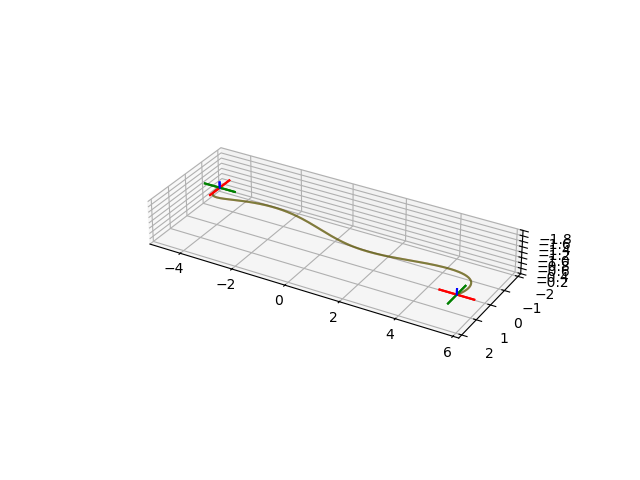

In [8]:
# Simulate within the FiGS environment
for gsplat, method, frame, policy, course, fext in simulate_examples:
    print("=============================================================")
    print(f"Simulating {gsplat} scene with {course} course")
    print("-------------------------------------------------------------")
    
    # Load the configs
    gsplat = ch.get_gsplat(gsplat)
    method = ch.get_config(method,"methods")
    course = ch.get_config(course,"courses")
    frame = ch.get_config(frame,"frames")
    policy = ch.get_config(policy,"pilots")
    
    # Load the policy and simulator
    sim = Simulator(gsplat,method["rollout"],frame,course["forces"])
    ctl = VehicleRateMPC(policy,course,frame)

    # Use the ideal trajectory in VehicleRateMPC to get initial conditions and final time
    t0,tf,x0 = ctl.tXUd[0,0],ctl.tXUd[0,-1],ctl.tXUd[1:11,0]

    # Get desired trajectory
    Tds,Xds,Uds = ctl.tXUd[0,:],ctl.tXUd[1:11,:],ctl.tXUd[11:,:]

    # Simulate the policy
    Tro,Xro,Uro,Imgs,_,_ = sim.simulate(ctl,t0,tf,x0)
    
    ROs = [(Tds,Xds,Uds),(Tro,Xro,Uro)]

    # Output the results
    gv.images_to_mp4(Imgs,'figs_output.mp4', ctl.hz)        # Save the video
    pt.plot_RO_3D(ROs)                                 # Plot the trajectories